In [27]:
from IPython.display import Image
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.colors import ListedColormap
import numpy as np
import itertools
%matplotlib inline

### Mondrian Processes

A *Mondrian Process* is a prior over kd-trees.

#### Sampling from a Mondrian Process

Define functions for sampling a Mondrian Process, given a budget parameter...

In [17]:
def draw_Mondrian(theta_space, budget=5):
    return draw_Mondrian_at_t(theta_space, 0, budget)
    
def draw_Mondrian_at_t(theta_space, t, budget):
    dists = theta_space[:,1] - theta_space[:,0]
    lin_dim = np.sum(dists)
    T = np.random.exponential(scale=1./lin_dim)
    
    if t+T > budget: 
        return (theta_space, None, None)
    
    d = np.argmax(np.random.multinomial(n=1, pvals=dists/lin_dim))
    x = np.random.uniform(low=theta_space[d,0], high=theta_space[d,1])
    
    theta_left = np.copy(theta_space)
    theta_left[d][1] = x 
    M_left = draw_Mondrian_at_t(theta_left, t+T, budget)
    
    theta_right = np.copy(theta_space)
    theta_right[d][0] = x 
    M_right = draw_Mondrian_at_t(theta_right, t+T, budget)
    
    return (theta_space, M_left, M_right)

Now define a function for visualizing the partitions...

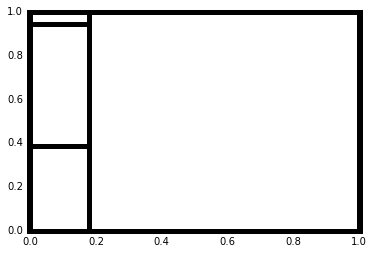

In [18]:
Z = np.array([[0.,1.],[0.,1.]])
parts = draw_Mondrian(Z, 1.)

plt.figure()

def print_partitions(p):
    if not p[1] and not p[2]: 
        plt.plot([p[0][0,0], p[0][0,0]], [p[0][1,0], p[0][1,1]], '-k', linewidth=5)
        plt.plot([p[0][0,1], p[0][0,1]], [p[0][1,0], p[0][1,1]], '-k', linewidth=5)
        plt.plot([p[0][0,0], p[0][0,1]], [p[0][1,0], p[0][1,0]], '-k', linewidth=5)
        plt.plot([p[0][0,0], p[0][0,1]], [p[0][1,1], p[0][1,1]], '-k', linewidth=5)
    
    else:
        print_partitions(p[1])
        print_partitions(p[2])

print_partitions(parts)

plt.xlim(-0.01,1.01)
plt.ylim(-0.01,1.01)
plt.show()

#### Mondrian Process Data Model

Now consider the following data model:

$$ \mathcal{M}_{1}, \ldots, \mathcal{M}_{K} \sim \text{Mondrian}(\lambda_{0}) \text{, } \ \ \mathbf{x}_{i} \sim Uniform(\mathcal{M}_{k}) $$ where $\mathcal{M}_{k}$ is the $k$th resulting partition drawn from the MP with budget $\lambda_{0}$.  The data is then drawn uniformly over the region $\mathcal{M}_{k}$.  We desire $p(\mathcal{M}_{1}, \ldots, \mathcal{M}_{K} \  | \  \mathbf{X})$, the posterior probability of the partitioning structure.  Notice that since each $\mathcal{M}_{k}$ is itself a proper Mondrian Processes---due to the self-consistency property---and therefore we could place priors at the partition level instead of the root level, like so:
$$ \mathcal{M}_{k} \sim \text{Mondrian}(\lambda_{k}) \text{, } \ \ \mathbf{x}_{i} \sim Uniform(\mathcal{M}_{k}).$$  This construction allows the propability of each partition to be calculated easily, as it is just the propbabily that the Mondrian process stops dividing: $$p(\mathcal{M}_{k} | \lambda_{k}) = \exp\{ -\lambda_{k} \  | \  \mathcal{M}_{k} | \}.$$

Let's generate some clustered data to fit this model to...

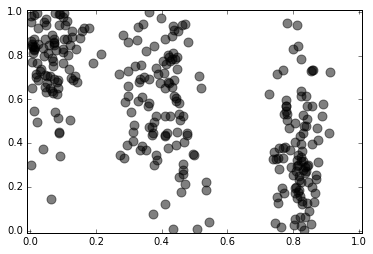

In [21]:
data = []
N = 300
mus = np.array([[.05, .81], [.4, .55], [.82, .3]])
sigmas = np.array([[.05, .2], [.07, .3], [.04, .3]])

### Generate from three Gaussians, ensuring samples respect boundary conditions
for idx in xrange(N):
    
    r = np.random.randint(low=0, high=3)
    good_sample = False
    while not good_sample:
        temp = [np.random.normal(loc=mus[r,0], scale=sigmas[r,0]), np.random.normal(loc=mus[r,1], scale=sigmas[r,1])]
        if temp[0] > 0 and temp[0] < 1 and temp[1] > 0 and temp[1] < 1: good_sample = True
            
    data.append(temp)
data = np.array(data)
    
plt.figure()
plt.scatter(data[:,0], data[:,1], c='k', edgecolors='k', s=80, alpha=.5)

plt.xlim(-0.01,1.01)
plt.ylim(-0.01,1.01)
plt.show()

#### Inference

Unfortunately, Mondrian Processes (MPs) are non-conjugate, and moreover, no deterministic algorithm for fitting them is known.  Thus, we resort to sampling-based inference to obtain the MP's posterior.  

##### Accept-Reject Algorithm

A simple, yet possibly ineffecient, way to obtain an MP's posterior is thought the accept-reject algorithm, using the ratio $ p(\mathbf{X} \ | \ \hat{\mathcal{M}}_{1},\ldots,\hat{\mathcal{M}}_{J}) \ / \ p(\mathbf{X} \ | \ \hat{\mathcal{M}}^{\text{MLE}}_{1},\ldots,\hat{\mathcal{M}}^{\text{MLE}}_{K}) $ where the partitions in the numerator is sampled from the prior $\{ \hat{\mathcal{M}}_{1},\ldots,\hat{\mathcal{M}}_{J} \} \sim \text{Mondrian}(\lambda_{0})$ and the partitions in the denominator are a maximum likelihood estimate (MLE).  

Unfortunately, maximum likelihood estimation, too, is intractable for Mondrian Processes.  We will approximate the MLE by running K-medians on the data...    

In [79]:
def get_median_assignment(data_point, medians):
    min_d = 1000.
    assign_idx = -1
        
    for k_idx, median in enumerate(medians):    
        l1_dist = np.sum(np.abs(data_point-median))
        if l1_dist <= min_d: 
            assign_idx = k_idx
            min_d = l1_dist
            
    return assign_idx, min_d


### K-Medians Algorithm

# Parameters
K = 1
lambda_k = .75  # should be set similarly to prior
max_iterations = 1000

# Initialize
N = data.shape[0]
medians = [np.array([np.random.uniform(low=0,high=1), np.random.uniform(low=0,high=1)]) for k in xrange(K)]

# Run algorithm
change = True
assignments = [-1] * N
iteration = 0 
while change and iteration < max_iterations:
    change = False
    iteration += 1
    
    # assign points to partition
    for d_idx in xrange(N):
        
        assign_idx, min_d = get_median_assignment(data[d_idx], medians)

        if min_d > 1./(2*lambda_k):
            medians.append(0.+data[d_idx])
            assignments[d_idx] = len(medians)
            change = True
        else:
            if assignments[d_idx] != assign_idx: change = True
            assignments[d_idx] = assign_idx
            
    # calculate new medians
    for k_idx in xrange(len(medians)):
        assigned_x = []
        for d_idx in xrange(N):
            if assignments[d_idx] == k_idx:
                assigned_x.append(data[d_idx,:])
                
        if len(assigned_x) > 0:
            medians[k_idx] = np.median(np.array(assigned_x), axis=0)
        else: 
            medians[k_idx] = np.array([-10,-10])

final_medians = medians  
final_assignments = np.array(assignments)

bounds = []
for k_idx in np.unique(final_assignments):
    idxs = np.nonzero(final_assignments==k_idx)[0]
    bounds.append( [(data[idxs,0].min(), data[idxs,0].max()), (data[idxs,1].min(), data[idxs,1].max())] )
    
print bounds

[[(0.72737547001156289, 0.91222112797899935), (0.41232513311139962, 0.94756788597947716)], [(0.43501774118830572, 0.87658731130985446), (0.00098402666022356922, 0.40415372814003853)], [(0.00029787976627178303, 0.34163078788313628), (0.64024073541318183, 0.99605051286105217)], [(0.26836190247170588, 0.51826667656749958), (0.076174579652848962, 0.99715500028826964)], [(0.00094276309321371377, 0.31361241524644456), (0.14314255387023378, 0.63441891373230164)]]


In [103]:
#Calculate Maximum Likelihood Estimate
p_MLE = 1.
for k_idx in np.unique(final_assignments):
    k_count = len(np.nonzero(final_assignments==k_idx)[0])
    p_MLE *= (1./((bounds[k_idx][0][1]-bounds[k_idx][0][0])*(bounds[k_idx][1][1]-bounds[k_idx][1][0])))**k_count
    
    
def get_Mondrian_partition_bounds(p):
    if not p[1] and not p[2]: 
        return [[(p[0][0,0], p[0][0,1]), (p[0][1,0], p[0][1,1])]]
    else:
        return get_Mondrian_partition_bounds(p[1]) + get_Mondrian_partition_bounds(p[2])

mcmc_its = 100
samples = []
rejects = []
for idx in xrange(mcmc_its):
    sample = draw_Mondrian(Z, 1.)
    sample_bounds = get_Mondrian_partition_bounds(sample)
    
    p_sample = 1.
    for n in xrange(N):
        for k in xrange(len(sample_bounds)):
            if data[n,0] > sample_bounds[k][0][0] and data[n,0] < sample_bounds[k][0][1] \
            and data[n,1] > sample_bounds[k][1][0] and data[n,0] < sample_bounds[k][1][1]:
                p_sample *= 1./((sample_bounds[k][0][1]-sample_bounds[k][0][0])*(sample_bounds[k][1][1]-sample_bounds[k][1][0]))
    
    # perform accept-reject step
    p_ratio = np.exp(np.log(p_sample)-np.log(p_MLE))
    if p_ratio >= np.random.uniform(low=0, high=1.):
        samples.append(sample)
    else:
        rejects.append(sample)
        
print len(samples)

24


/Users/enalisnick/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: overflow encountered in double_scalars


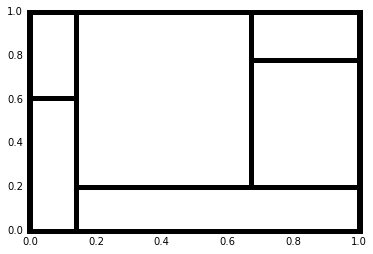

In [108]:
print_partitions(samples[0])

plt.xlim(-0.01,1.01)
plt.ylim(-0.01,1.01)
plt.show()

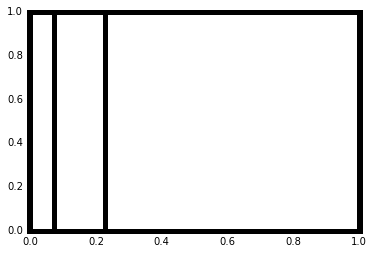

In [111]:
print_partitions(rejects[5])

plt.xlim(-0.01,1.01)
plt.ylim(-0.01,1.01)
plt.show()